In [1]:
# Import necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
# Load in the data

df = pd.read_csv('Spotify_Christmas_Streams.csv')

In [5]:
# Clean datetimes

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [7]:
# Add the seasonality effect of Christmas

christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime([
        '2017-12-25','2018-12-25','2019-12-25','2020-12-25',
        '2021-12-25','2022-12-25','2023-12-25','2024-12-25',
        '2025-12-25','2026-12-25'
    ]),
    'lower_window': -14,
    'upper_window': 7
})

In [9]:
# Weekly series for each track

results = []
tracks = df['track'].unique()

In [11]:
# Loop through tracks for 2026 analysis

for track in tracks:
    track_df = df[df['track'] == track].copy()

    # Build full weekly calendar
    full_weeks = pd.date_range(
        start=track_df['date'].min(),
        end='2026-12-31',
        freq='W-THU'
    )

    prophet_df = pd.DataFrame({'ds': full_weeks})
    prophet_df = prophet_df.merge(
        track_df[['date', 'streams']],
        left_on='ds',
        right_on='date',
        how='left'
    ).drop(columns='date')

    prophet_df['y'] = prophet_df['streams'].fillna(0)
    prophet_df['floor'] = 0
    prophet_df = prophet_df[['ds', 'y', 'floor']]

    # Fit refined Prophet model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=christmas,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05
    )

    m.fit(prophet_df)

    # Forecast into 2026
    future = m.make_future_dataframe(periods=20, freq='W-THU')
    forecast = m.predict(future)

    # Extract Christmas 2026 peak
    peak_2026 = forecast[
        (forecast['ds'].dt.year == 2026) &
        (forecast['ds'].dt.isocalendar().week >= 46)
    ]['yhat'].max()

    results.append({
        'track': track,
        'predicted_peak_streams_2026': peak_2026
    })

12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:50:58 - cmdstanpy - INFO - Chain [1] done processing
12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] done processing
12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing
12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing
12:51:01 - cmdstanpy - INFO - Chain [1] start processing
12:51:01 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# 2026 Leaderboard
leaderboard = (
    pd.DataFrame(results)
      .sort_values('predicted_peak_streams_2026', ascending=False)
)

leaderboard.head(10)

,track,predicted_peak_streams_2026
0,All I Want for Christmas Is You,2.462295e+07
1,Last Christmas,2.234732e+07
4,Santa Tell Me,1.818992e+07
3,Rockin' Around the Christmas Tree,1.751403e+07
2,It's Beginning to Look a Lot Like Christmas,1.696577e+07
6,Jingle Bell Rock,1.694218e+07
5,Feliz Navidad,1.151334e+07


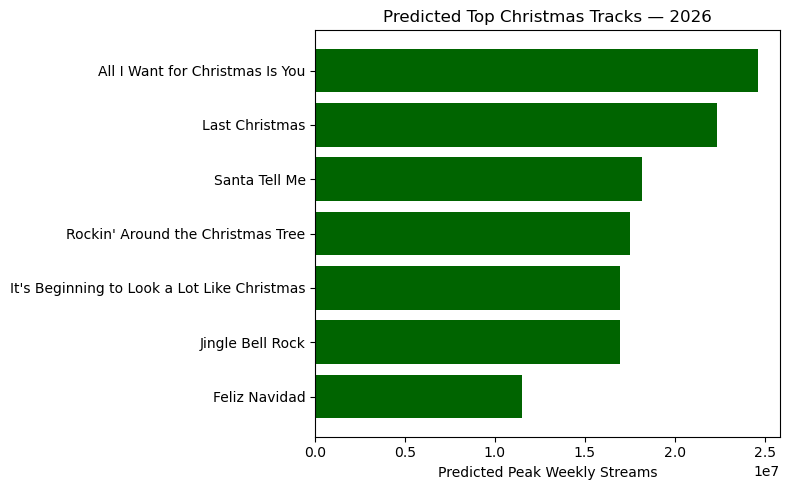

In [15]:
# Visualization of leaderboard

top_10 = leaderboard.head(10)

plt.figure(figsize=(8, 5))
plt.barh(
    top_10['track'][::-1],
    top_10['predicted_peak_streams_2026'][::-1],
    color='darkgreen'
)

plt.title("Predicted Top Christmas Tracks — 2026")
plt.xlabel("Predicted Peak Weekly Streams")
plt.tight_layout()
plt.show()
